In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data_path = "/media/magesh/HardDisk/Thesis/anomaly_detection/data/processed/ml_data"


csv_files = [ file for file in os.listdir(data_path) if file.endswith(".csv")]

dataframes = []

for index, file in enumerate(csv_files):
    data = pd.read_csv(os.path.join(data_path,file))
    sensor_name = data.columns[2]
    data = data.rename(columns={sensor_name:'synthetic_signal'})
    data[sensor_name] = index
    
    dataframes.append(data)


combined_df = pd.concat(dataframes,ignore_index=True)

In [3]:
combined_df

,Timestamp,original_signal,synthetic_signal,step_variable_ws5,step_variable_ws10,step_variable_ws15,std_anomaly_ws5,std_anomaly_ws10,std_anomaly_ws15,iqr_anomaly_ws5,iqr_anomaly_ws10,iqr_anomaly_ws15,Anomaly,S23_Sensore-di-temperatura-e-umidit_Humidity_perc,S10_Flussimetro_Velocity_m_s,S17_MIT-Mandata_1PhPow_W_L3,S2_MIT-Ripresa_3PhNrg_kWh_L3
0,11-05-2023 00:10,74.08,74.08,0,0,0,1,0,0,0,0,0,0.0,0.0,NaN,NaN,NaN
1,11-05-2023 00:19,74.08,74.08,0,0,0,1,0,0,0,0,0,0.0,0.0,NaN,NaN,NaN
2,11-05-2023 00:20,73.58,73.58,0,0,0,0,0,0,0,0,0,0.0,0.0,NaN,NaN,NaN
3,11-05-2023 00:30,73.58,73.58,0,0,0,1,0,0,0,0,0,0.0,0.0,NaN,NaN,NaN
4,11-05-2023 00:40,73.58,73.58,0,0,0,1,0,0,0,0,0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9435,10-06-2023 10:40,51.51,51.51,0,0,0,0,0,0,1,0,0,0.0,NaN,NaN,NaN,3.0
9436,10-06-2023 10:50,51.79,51.79,0,0,0,1,0,0,1,0,1,0.0,NaN,NaN,NaN,3.0
9437,10-06-2023 10:59,51.79,146.59,0,0,0,1,1,1,1,1,1,1.0,NaN,NaN,NaN,3.0
9438,10-06-2023 11:00,52.07,52.07,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,3.0


In [4]:
combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'],dayfirst=True)
combined_df['Day'] = combined_df['Timestamp'].dt.day
combined_df['Month'] = combined_df['Timestamp'].dt.month
combined_df['Year'] = combined_df['Timestamp'].dt.year
combined_df['Hour'] = combined_df['Timestamp'].dt.hour
combined_df['Minute'] = combined_df['Timestamp'].dt.minute


columns_order = ['Day', 'Month', 'Year', 'Hour', 'Minute', 'original_signal', 'synthetic_signal',
                 'step_variable_ws5', 'step_variable_ws10', 'step_variable_ws15',
                 'std_anomaly_ws5', 'std_anomaly_ws10', 'std_anomaly_ws15',
                 'iqr_anomaly_ws5', 'iqr_anomaly_ws10', 'iqr_anomaly_ws15',
                 'S23_Sensore-di-temperatura-e-umidit_Humidity_perc',
                 'S10_Flussimetro_Velocity_m_s',
                 'S17_MIT-Mandata_1PhPow_W_L3',
                 'S2_MIT-Ripresa_3PhNrg_kWh_L3',
                 'Anomaly']

combined_df = combined_df[columns_order]

# combined_df = combined_df.drop('Timestamp',axis = 1)

In [5]:
combined_df = combined_df.fillna(0)
combined_df.isna().sum()

Day                                                  0
Month                                                0
Year                                                 0
Hour                                                 0
Minute                                               0
original_signal                                      0
synthetic_signal                                     0
step_variable_ws5                                    0
step_variable_ws10                                   0
step_variable_ws15                                   0
std_anomaly_ws5                                      0
std_anomaly_ws10                                     0
std_anomaly_ws15                                     0
iqr_anomaly_ws5                                      0
iqr_anomaly_ws10                                     0
iqr_anomaly_ws15                                     0
S23_Sensore-di-temperatura-e-umidit_Humidity_perc    0
S10_Flussimetro_Velocity_m_s                         0
S17_MIT-Ma

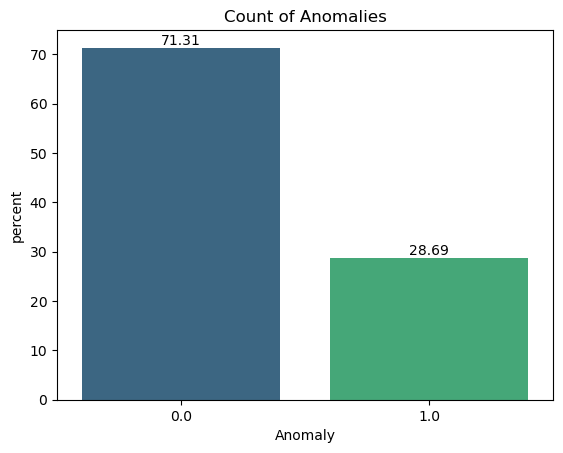

In [6]:
ax = sns.countplot(data=combined_df, x='Anomaly', palette='viridis',stat='percent')  

labels = (combined_df.Anomaly.value_counts().values) / len(combined_df) * 100 
labels = np.around(labels, 2)

for bar, label in zip(ax.patches, labels):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{label}',
        ha='center',
        va='bottom'
    )

plt.title('Count of Anomalies')
plt.show()


In [7]:
X = combined_df.drop('Anomaly',axis = 1)
X

,Day,Month,Year,Hour,Minute,original_signal,synthetic_signal,step_variable_ws5,step_variable_ws10,step_variable_ws15,std_anomaly_ws5,std_anomaly_ws10,std_anomaly_ws15,iqr_anomaly_ws5,iqr_anomaly_ws10,iqr_anomaly_ws15,S23_Sensore-di-temperatura-e-umidit_Humidity_perc,S10_Flussimetro_Velocity_m_s,S17_MIT-Mandata_1PhPow_W_L3,S2_MIT-Ripresa_3PhNrg_kWh_L3
0,11,5,2023,0,10,74.08,74.08,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0
1,11,5,2023,0,19,74.08,74.08,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0
2,11,5,2023,0,20,73.58,73.58,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,11,5,2023,0,30,73.58,73.58,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0
4,11,5,2023,0,40,73.58,73.58,0,0,0,1,0,0,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9435,10,6,2023,10,40,51.51,51.51,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,3.0
9436,10,6,2023,10,50,51.79,51.79,0,0,0,1,0,0,1,0,1,0.0,0.0,0.0,3.0
9437,10,6,2023,10,59,51.79,146.59,0,0,0,1,1,1,1,1,1,0.0,0.0,0.0,3.0
9438,10,6,2023,11,0,52.07,52.07,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,3.0


In [8]:
y = combined_df['Anomaly']
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9435    0.0
9436    0.0
9437    1.0
9438    0.0
9439    0.0
Name: Anomaly, Length: 9440, dtype: float64

In [9]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 0.8 / 0.2 = 1

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2

In [10]:
X_train.shape,X_val.shape,X_test.shape

((5664, 20), (1888, 20), (1888, 20))

Validation Accuracy: 0.7219
Test Accuracy: 0.7166
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      1.00      0.83      1353
         1.0       0.00      0.00      0.00       535

    accuracy                           0.72      1888
   macro avg       0.36      0.50      0.42      1888
weighted avg       0.51      0.72      0.60      1888



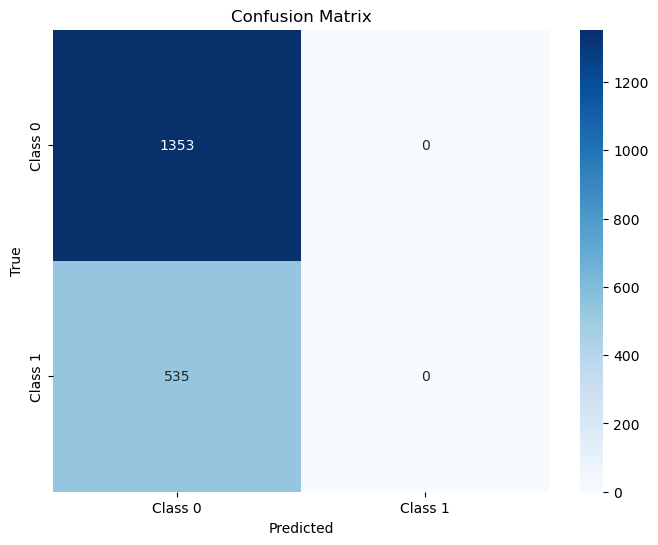

In [11]:
def build_simple_model(X_train, X_val, X_test, y_train, y_val, y_test):
    # Initialize and train the model
    model = SVC()
    model.fit(X_train, y_train)
    
    # Validate the model
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Test the model
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Print additional metrics
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model

# Example usage (assuming you have already split your data into X_train, X_val, X_test, y_train, y_val, y_test)
model = build_simple_model(X_train, X_val, X_test, y_train, y_val, y_test)


Validation Accuracy: 0.9725
Test Accuracy: 0.9693
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1353
         1.0       0.96      0.93      0.94       535

    accuracy                           0.97      1888
   macro avg       0.97      0.96      0.96      1888
weighted avg       0.97      0.97      0.97      1888



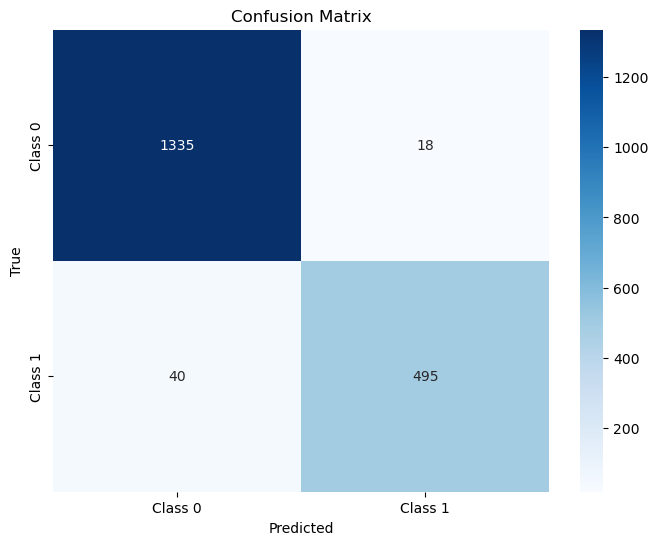

In [12]:
def build_simple_model(X_train, X_val, X_test, y_train, y_val, y_test):
    # Initialize and train the model
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # Validate the model
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Test the model
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Print additional metrics
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model

# Example usage (assuming you have already split your data into X_train, X_val, X_test, y_train, y_val, y_test)
model = build_simple_model(X_train, X_val, X_test, y_train, y_val, y_test)

Validation Accuracy: 0.9518
Test Accuracy: 0.9481
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      1353
         1.0       0.94      0.87      0.90       535

    accuracy                           0.95      1888
   macro avg       0.95      0.92      0.93      1888
weighted avg       0.95      0.95      0.95      1888



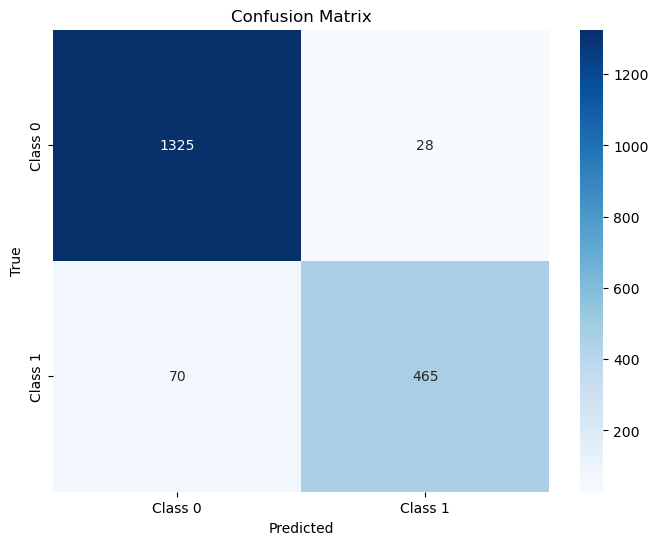

In [13]:
def build_model_scaler(X_train, X_val, X_test, y_train, y_val, y_test):
    
    # Create a pipeline with scaling and model
    model = Pipeline(
        [ ('scaler',RobustScaler()),
        ('svc',SVC())
        ]
    )
    model.fit(X_train, y_train)
    
    # Validate the model
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Test the model
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Print additional metrics
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model

# Example usage (assuming you have already split your data into X_train, X_val, X_test, y_train, y_val, y_test)
model = build_model_scaler(X_train, X_val, X_test, y_train, y_val, y_test)


Validation Accuracy: 0.9703
Test Accuracy: 0.9619
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1353
         1.0       0.91      0.96      0.93       535

    accuracy                           0.96      1888
   macro avg       0.95      0.96      0.95      1888
weighted avg       0.96      0.96      0.96      1888



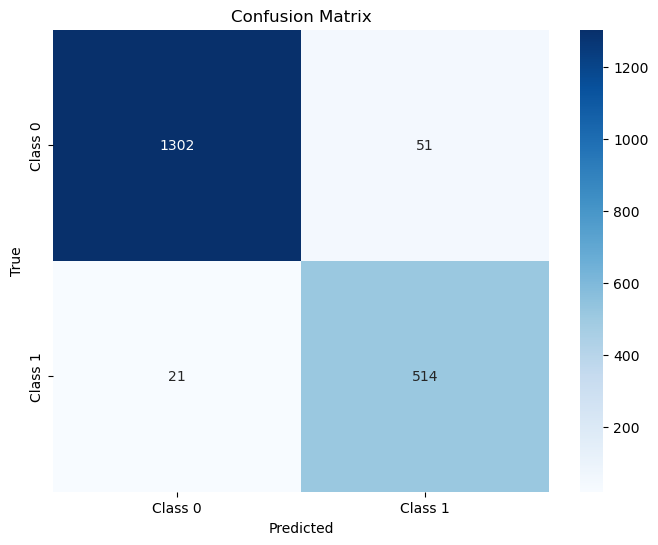

Best SVC Hyperparameters: {'svc__kernel': 'rbf', 'svc__gamma': 1, 'svc__class_weight': 'balanced', 'svc__C': 100}


Pipeline(steps=[('scaler', RobustScaler()),
                ('svc', SVC(C=100, class_weight='balanced', gamma=1))])

In [18]:
def build_model_with_hyperparameter_tuning(X_train, X_val, X_test, y_train, y_val, y_test):

    # Create a pipeline with scaling and model
    pipeline = Pipeline(
        [('scaler', RobustScaler()),
         ('svc', SVC())]
    )
    
    # Define a parameter grid for RandomizedSearchCV
    param_grid = {
        'svc__C': [0.1, 1, 10, 100],
        'svc__kernel': ['linear', 'rbf'],
        'svc__gamma': ['scale', 'auto', 0.1, 1, 10],  # Relevant for 'rbf'
        'svc__class_weight': [None, 'balanced']
    }
    
    random_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Train the model with RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Best model from RandomizedSearchCV
    best_model = random_search.best_estimator_

    # Save the SVC Model.
    joblib.dump(best_model,'/media/magesh/HardDisk/Thesis/anomaly_detection/models/SVC_model.pkl')
    
    # Make predictions and validate
    y_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Test the model
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Print additional metrics
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f"Best SVC Hyperparameters: {random_search.best_params_}")
    return best_model

svc_hyperparameter = build_model_with_hyperparameter_tuning(X_train, X_val, X_test, y_train, y_val, y_test)
svc_hyperparameter


Validation Accuracy: 0.9772
Test Accuracy: 0.9762
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1353
         1.0       0.98      0.94      0.96       535

    accuracy                           0.98      1888
   macro avg       0.98      0.96      0.97      1888
weighted avg       0.98      0.98      0.98      1888



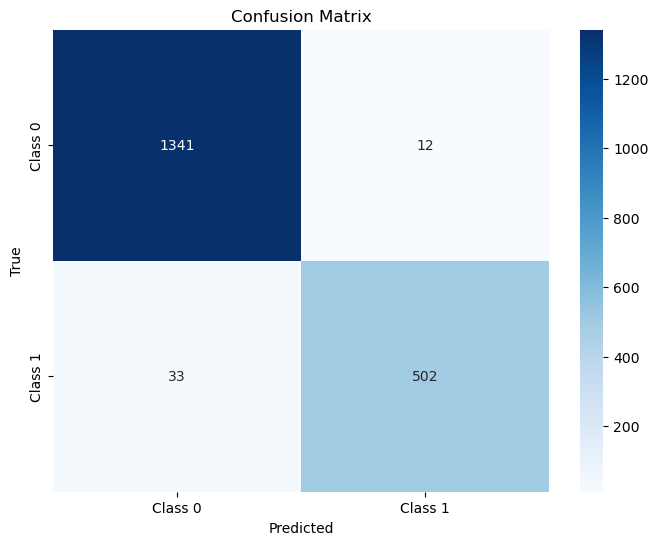

Best RF Hyperparameters: {'n_estimators': 105, 'max_features': 12, 'max_depth': 11}


RandomForestClassifier(max_depth=11, max_features=12, n_estimators=105)

In [17]:
def build_model_with_hyperparameter_tuning(X_train, X_val, X_test, y_train, y_val, y_test):
    
    # Define a parameter grid for RandomizedSearchCV
    param_grid = [{'n_estimators' : list(range(100,110)), 
                      'max_depth': list(range(10, 15)), 
                      'max_features': list(range(0,14))}
                    ]
    
    # Initialize the model and RandomizedSearchCV
    model = RandomForestClassifier()
    random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy')
    
    # Train the model with RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Best model from RandomizedSearchCV
    best_model = random_search.best_estimator_

    # Save the SVC Model.
    joblib.dump(best_model,'/media/magesh/HardDisk/Thesis/anomaly_detection/models/RF_model.pkl')
    
    # Make predictions and evaluate
    y_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    
    # Test the model
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Print additional metrics
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f"Best RF Hyperparameters: {random_search.best_params_}")
    return best_model

rf_hyperparameter = build_model_with_hyperparameter_tuning(X_train, X_val, X_test, y_train, y_val, y_test)
rf_hyperparameter
